In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation
from qiskit.circuit.library import LogNormalDistribution, LinearAmplitudeFunction

In [2]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0       # initial spot price
vol = 0.4     # volatility of 40%
r = 0.05      # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

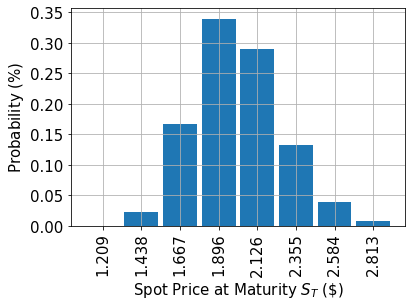

In [3]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

In [4]:
print(uncertainty_model.probabilities)

[0.00045374 0.02293123 0.16681763 0.33977531 0.28936531 0.13310021
 0.0392238  0.00833277]


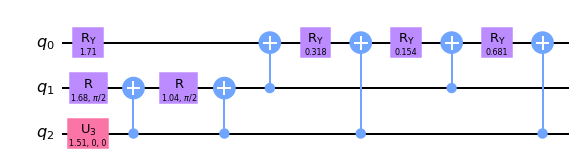

In [5]:
uncertainty_model.decompose().decompose().decompose().draw('mpl')

{'000': 1, '001': 22, '010': 167, '011': 350, '100': 305, '101': 132, '110': 36, '111': 11}


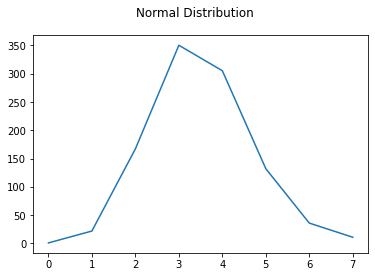

In [6]:
## Test uncertainty model distribution
q = QuantumRegister(num_uncertainty_qubits,'q')
c = ClassicalRegister(num_uncertainty_qubits,'c')
backend = Aer.get_backend('qasm_simulator')
test_circuit = QuantumCircuit(q, c)
test_circuit.append(uncertainty_model, list(range(num_uncertainty_qubits)))
test_circuit.measure(q,c)
job = execute(test_circuit, backend, shots=1024)
counts = job.result().get_counts()

print(counts)
sortedcounts = []
sortedkeys = sorted(counts)

for i in sortedkeys:
    for j in counts:
        if(i == j):
            sortedcounts.append(counts.get(j))

plt.suptitle('Normal Distribution')
plt.plot(sortedcounts)
plt.show()

In [7]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.896

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw()

┌───────┐┌────┐
q_0: ┤0      ├┤0   ├
     │       ││    │
q_1: ┤1 P(X) ├┤1   ├
     │       ││    │
q_2: ┤2      ├┤2   ├
     └───────┘│    │
q_3: ─────────┤3 F ├
              │    │
q_4: ─────────┤4   ├
              │    │
q_5: ─────────┤5   ├
              │    │
q_6: ─────────┤6   ├
              └────┘

In [8]:
european_call.decompose().draw()

»
q_0: ───────────────────────────────────────────────────»
                              ┌────────────────────────┐»
q_1: ─────────────────────────┤0                       ├»
     ┌───────────────────────┐│  multiplex2_reverse_dg │»
q_2: ┤ multiplex1_reverse_dg ├┤1                       ├»
     └───────────────────────┘└────────────────────────┘»
q_3: ───────────────────────────────────────────────────»
                                                        »
q_4: ───────────────────────────────────────────────────»
                                                        »
q_5: ───────────────────────────────────────────────────»
                                                        »
q_6: ───────────────────────────────────────────────────»
                                                        »
«     ┌────────────────────────┐┌─────────┐┌──────┐┌─────────┐┌─────────┐
«q_0: ┤0                       ├┤0        ├┤0     ├┤0        ├┤0        ├
«     │                        ││         ││      ││         ││         │
«q_1: ┤1 multiplex3_reverse_dg ├┤1        ├┤1     ├┤1        ├┤1        ├
«     │                        ││  LinRot ││      ││  LinRot ││         │
«q_2: ┤2                       ├┤2        ├┤2     ├┤2        ├┤2        ├
«     └────────────────────────┘│         ││      ││         ││         │
«q_3: ──────────────────────────┤3        ├┤  cmp ├┤3        ├┤  cmp_dg ├
«                               └─────────┘│      │└────┬────┘│         │
«q_4: ─────────────────────────────────────┤3     ├─────■─────┤3        ├
«                                          │      │           │         │
«q_5: ─────────────────────────────────────┤4     ├───────────┤4        ├
«                                          │      │           │         │
«q_6: ─────────────────────────────────────┤5     ├───────────┤5        ├
«                                          └──────┘           └─────────┘

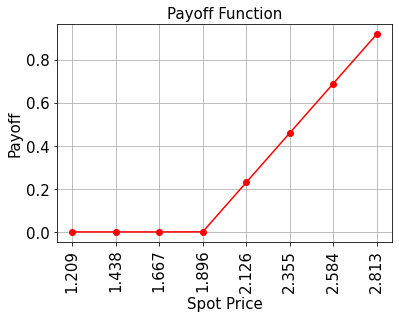

In [9]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [10]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print('exact expected value:\t%.4f' % exact_value)
print('exact delta value:   \t%.4f' % exact_delta)

exact expected value:	0.1623
exact delta value:   	0.8098


In [11]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha,
                                  state_preparation=european_call,
                                  objective_qubits=[3],
                                  post_processing=european_call_objective.post_processing)

In [12]:
result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)


In [13]:
conf_int = np.array(result['confidence_interval'])
print('Exact value:        \t%.4f' % exact_value)
print('Estimated value:    \t%.4f' % (result['estimation']))
print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1669
Confidence interval:	[0.1609, 0.1728]


In [14]:
# Evaluate delta

from qiskit.finance.applications import EuropeanCallDelta

european_call_delta = EuropeanCallDelta(num_uncertainty_qubits, strike_price, bounds=(low, high))

In [15]:
european_call_delta.decompose().draw()


state_0: ───────■─────────────────────────────■──
                │                             │  
state_1: ───────┼────■───────────────────■────┼──
         ┌───┐  │    │            ┌───┐  │    │  
state_2: ┤ X ├──┼────┼─────────■──┤ X ├──┼────┼──
         ├───┤  │    │       ┌─┴─┐└───┘  │    │  
state_3: ┤ X ├──┼────┼───────┤ X ├───────┼────┼──
         └───┘┌─┴─┐  │       └─┬─┘       │  ┌─┴─┐
 work_0: ─────┤ X ├──■─────────┼─────────■──┤ X ├
              └───┘┌─┴─┐┌───┐  │  ┌───┐┌─┴─┐└───┘
 work_1: ──────────┤ X ├┤ X ├──■──┤ X ├┤ X ├─────
                   └───┘└───┘     └───┘└───┘

In [16]:
state_preparation = QuantumCircuit(european_call_delta.num_qubits)
state_preparation.append(uncertainty_model, range(uncertainty_model.num_qubits))
state_preparation.append(european_call_delta, range(european_call_delta.num_qubits))
state_preparation.draw()

┌───────┐┌──────┐
q_0: ┤0      ├┤0     ├
     │       ││      │
q_1: ┤1 P(X) ├┤1     ├
     │       ││      │
q_2: ┤2      ├┤2     ├
     └───────┘│  ECD │
q_3: ─────────┤3     ├
              │      │
q_4: ─────────┤4     ├
              │      │
q_5: ─────────┤5     ├
              └──────┘

In [17]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation
ae_delta = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha,
                                        state_preparation=state_preparation,
                                        objective_qubits=[num_uncertainty_qubits])

In [18]:
result_delta = ae_delta.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)


In [19]:
conf_int = np.array(result_delta['confidence_interval'])
print('Exact delta:    \t%.4f' % exact_delta)
print('Esimated value: \t%.4f' % result_delta['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

Exact delta:    	0.8098
Esimated value: 	0.8125
Confidence interval: 	[0.8078, 0.8172]
